In [1]:
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Embedding, regularizers
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.merge import Concatenate
from keras import optimizers
from keras import backend as K
from w2v import train_word2vec 
import pickle, datetime
import numpy as np
import difflib

Using TensorFlow backend.


# ------------------------------- Data Preprocessing -----------------------------------

### Phrase -> index

In [2]:
phr_to_ind = dict()

with open('../../Datasets/SST1_dataset/dictionary.txt') as f:
    for line in f:
        entry = line.split('|')
        phr_to_ind[entry[0]] = int(entry[1])

keys = phr_to_ind.keys();

print(len(phr_to_ind), phr_to_ind['Good'])

239232 14058


### Getting Index corresponding to sentences

In [3]:
# Without doing the below computation directly load the stored output
sentence_list = []
sentiment = []

with open('../../Datasets/SST1_dataset/SentenceWithCorrection.txt') as f:
    for line in f:
        sent = line[:-1]
        sentence_list.append(sent)
        sentiment.append(phr_to_ind[sent])

print(len(sentence_list))

11855


In [4]:
# sentence_list = []
# sentiment = []

# with open('../../Datasets/SST1_dataset/datasetSentences.txt') as f:
#     f.readline()
#     for line in f:
#         entry = line.split('\t')
#         sent = entry[1][:-1]
#         sent = sent.replace('-LRB-', '(')
#         sent = sent.replace('-RRB-', ')')
    
#         if sent in phr_to_ind.keys():
#             sentiment.append(phr_to_ind[sent])
#         else:
#             print('.', end="")
#             keys_subset = [k for k in keys if (k[0] == sent[0])]
#             key = difflib.get_close_matches(sent, keys_subset, n=1);
#             sent = key[0]
#             sentiment.append(phr_to_ind[sent])
            
#         sentence_list.append(sent)
        
# print(len(sentence_list))

# # Written the output in a file
# f = open('../../Datasets/SST1_dataset/SentenceWithCorrection.txt', 'w')
# for sent in sentence_list:
#     f.write(sent + '\n')
# f.close()

### Phrase Index -> Sentiment

In [5]:
ind_to_senti = dict()

with open('../../Datasets/SST1_dataset/sentiment_labels.txt') as f:
    f.readline()
    for line in f:
        entry = line.split('|')
        ind_to_senti[int(entry[0])] = float(entry[1])

print(len(ind_to_senti))

239232


### Loading train, test and valid split info

In [6]:
split_ind = []
with open('../../Datasets/SST1_dataset/datasetSplit.txt') as f:
    f.readline()
    for line in f:
        entry = line.split(',')
        split_ind.append(int(entry[1]))

print(len(split_ind))

for i in range(len(split_ind)):
    if split_ind[i] == 3:
        split_ind[i] = 1
        
N_train = split_ind.count(1)
N_test = split_ind.count(2)
N_valid = split_ind.count(3)
print (N_train, N_test, N_valid)

11855
9645 2210 0


### Assigning label to sentences

In [7]:
N_sent = len(sentence_list);
N_category = 5

y_label = []

for ind in sentiment:
    val = ind_to_senti[ind]
    if val >= 0.0 and val <= 0.2:
        y_label.append(0);
    elif val > 0.2 and val <= 0.4:
        y_label.append(1)
    elif val > 0.4 and val <= 0.6:
        y_label.append(2)
    elif val > 0.6 and val <= 0.8:
        y_label.append(3)
    else:
        y_label.append(4)

print(y_label.count(0), y_label.count(1), y_label.count(2), y_label.count(3))

# Labels in one-hot encoding
y_train = np.zeros((N_train, N_category), np.uint8)
y_test  = np.zeros((N_test , N_category), np.uint8)
y_valid = np.zeros((N_valid, N_category), np.uint8)

c1,c2,c3 = 0,0,0
for i in range(len(y_label)):
    label = y_label[i]
    if split_ind[i] == 1:
        y_train[c1, label] = 1;  c1 += 1
    elif split_ind[i] == 2:
        y_test [c2, label] = 1;  c2 += 1
    else:
        y_valid[c3, label] = 1;  c3 += 1

1510 3140 2242 3111


### Reducing the size of vocabulary

In [8]:
x_all = []
max_sent_len = -1;
max_wrd_len = -1
wrd_to_ind = dict()

ind_new = 1;
for sent in sentence_list:
    wrds = sent.split()
    vec = []
    for wrd in wrds:
        if wrd not in wrd_to_ind.keys():
            wrd_to_ind[wrd] = ind_new
            ind_new += 1
            
        ind = wrd_to_ind[wrd]
        vec.append(ind)
            
    max_sent_len = max(len(vec), max_sent_len)
    x_all.append(vec)

# Get inverse dictionary
ind_to_wrd = dict((v, k) for k, v in wrd_to_ind.items())
ind_to_wrd[0] = "<PAD/>"

print(len(phr_to_ind), len(wrd_to_ind))

239232 21699


### Create input features

In [9]:
x_train = np.zeros((N_train, max_sent_len), np.int32)
x_test  = np.zeros((N_test,  max_sent_len), np.int32)
x_valid = np.zeros((N_valid, max_sent_len), np.int32)

c1, c2, c3 = 0,0,0
for i in range(len(x_all)):
    vec = x_all[i]
    if split_ind[i] == 1:
        x_train[c1,0:len(vec)] = np.int32(vec); 
        c1 += 1
    elif split_ind[i] == 2:
        x_test [c2,0:len(vec)] = np.int32(vec); 
        c2 += 1
    else:
        x_valid[c3,0:len(vec)] = np.int32(vec); 
        c3 += 1

print(c1, c2, c3)

9645 2210 0


# -------------------------------- Training model  -----------------------------------

### Model Paremeters

In [10]:
model_type    = 'CNN-static'  # CNN-rand|CNN-non-static|CNN-static
embedding_dim = 300         # word2vec dim
vocab_size    = len(ind_to_wrd)

### Generate word2vec 

In [11]:
if model_type in ['CNN-non-static', 'CNN-static']:
    embedding_wts = train_word2vec( np.vstack((x_train, x_test, x_valid)), 
                                    ind_to_wrd, num_features = embedding_dim)
    if model_type == 'CNN-static':
        x_train = embedding_wts[0][x_train]
        x_test  = embedding_wts[0][x_test]
#         x_valid = embedding_wts[0][x_valid]
        
elif model_type == 'CNN-rand':
    embedding_wts = None
    
else:
    raise ValueError("Unknown model type")

Load existing Word2Vec model '300features_1minwords_10context'


### Create model

In [12]:
batch_size   = 50
filter_sizes = [3,4,5]
num_filters  = 100
dropout_prob = (0.5, 0.8)
hidden_dims  = 100

l2_reg = 0.3

# Deciding dimension of input based on the model
input_shape = (max_sent_len, embedding_dim) if model_type == "CNN-static" else (max_sent_len,)
model_input = Input(shape = input_shape)

# Static model do not have embedding layer
if model_type == "CNN-static":
    z = Dropout(dropout_prob[0])(model_input)
else:
    z = Embedding(vocab_size, embedding_dim, input_length = max_sent_len, name="embedding", trainable=True)(model_input)
    z = Dropout(dropout_prob[0])(z)

# Convolution layers
z1 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[0], 
                padding="valid", activation="relu", 
                strides=1)(z)
z1 = MaxPooling1D(pool_size = max_sent_len - filter_sizes[0] +1)(z1)
z1 = Flatten()(z1)

z2 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[1], 
                padding="valid", activation="relu", 
                strides=1)(z)
z2 = MaxPooling1D(pool_size=max_sent_len - filter_sizes[1] +1)(z2)
z2 = Flatten()(z2)

z3 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[2], 
                padding="valid", activation="relu",
                strides=1)(z)
z3 = MaxPooling1D(pool_size=max_sent_len - filter_sizes[2] +1)(z3)
z3 = Flatten()(z3)

# Concatenate the output of all convolution layers
z = Concatenate()([z1, z2, z3])
z = Dropout(dropout_prob[1])(z)

z = Dense(hidden_dims, activation="relu")(z)
model_output = Dense(N_category, activation="softmax")(z)
    
model = Model(model_input, model_output)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 56, 300)       0                                            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 56, 300)       0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 54, 100)       90100                                        
____________________________________________________________________________________________________
conv1d_2 (Conv1D)                (None, 53, 100)       120100                                       
___________________________________________________________________________________________

### Train model 

In [ ]:
if model_type == "CNN-non-static":
    embedding_layer = model.get_layer("embedding")
    embedding_layer.set_weights(embedding_wts)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(), metrics=["accuracy"])

res = model.fit(x_train, y_train, 
          batch_size = batch_size,
          epochs=3000,
          validation_data=(x_test, y_test), verbose=2)

Train on 9645 samples, validate on 2210 samples
Epoch 1/3000
13s - loss: 1.5956 - acc: 0.2583 - val_loss: 1.5883 - val_acc: 0.2520
Epoch 2/3000
8s - loss: 1.5726 - acc: 0.2734 - val_loss: 1.5761 - val_acc: 0.2760
Epoch 3/3000
9s - loss: 1.5637 - acc: 0.2836 - val_loss: 1.5665 - val_acc: 0.3063
Epoch 4/3000
8s - loss: 1.5573 - acc: 0.2823 - val_loss: 1.5574 - val_acc: 0.3041
Epoch 5/3000
8s - loss: 1.5501 - acc: 0.2943 - val_loss: 1.5456 - val_acc: 0.3086
Epoch 6/3000
8s - loss: 1.5418 - acc: 0.3006 - val_loss: 1.5392 - val_acc: 0.3136
Epoch 7/3000
8s - loss: 1.5417 - acc: 0.3031 - val_loss: 1.5347 - val_acc: 0.3262
Epoch 8/3000
8s - loss: 1.5299 - acc: 0.3099 - val_loss: 1.5265 - val_acc: 0.3190
Epoch 9/3000
8s - loss: 1.5303 - acc: 0.3082 - val_loss: 1.5316 - val_acc: 0.3090
Epoch 10/3000
8s - loss: 1.5222 - acc: 0.3125 - val_loss: 1.5211 - val_acc: 0.3190
Epoch 11/3000
8s - loss: 1.5187 - acc: 0.3191 - val_loss: 1.5133 - val_acc: 0.3285
Epoch 12/3000
8s - loss: 1.5103 - acc: 0.3273 -

In [18]:
import os
os.system('say done')

256

### Computing Accuracy

In [14]:
# Training Accuracy
predictions = model.predict(x_train)
pred_train = np.argmax(predictions, axis=1)
train_label = np.argmax(y_train, axis=1)
print('Training Accuracy', np.sum(pred_train == train_label) / N_train * 100)

# # Training Accuracy
# predictions = model.predict(x_valid)
# pred_valid = np.argmax(predictions, axis=1)
# valid_label = np.argmax(y_valid, axis=1)
# print('Validation Accuracy', np.sum(pred_valid == valid_label) / N_valid * 100)

# Test Accuracy
predictions = model.predict(x_test)
pred_test = np.argmax(predictions, axis=1)
test_label = np.argmax(y_test, axis=1)
print('Testing Accuracy', np.sum(pred_test == test_label) / N_test * 100)

Training Accuracy 26.5422498704
Testing Accuracy 26.9683257919


### Save the model

In [19]:
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]

filename = '/home/shikhar/Datasets/Models/32_' + model_type + '_' + date + '_' +time;
with open( filename, 'wb') as output:
    pickle.dump([model.get_config(), model.get_weights(), model.history.history], output, pickle.HIGHEST_PROTOCOL)

### Plot the results

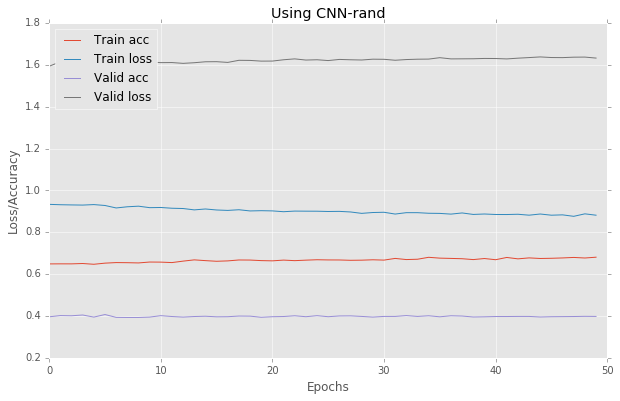

In [62]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(res.history['acc'])
plt.plot(res.history['loss'])
plt.plot(res.history['val_acc'])
plt.plot(res.history['val_loss'])
plt.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Using '+ model_type)
imgName = 'Images/' + model_type + '_' + date + '_' + time + '.jpg'
plt.savefig( imgName, dpi= 200, bbox_inches='tight', transparent=False)
plt.show()

### Continue from a pretrained model

In [13]:
# Loading saved data
import pickle

filename = '/home/shikhar/Datasets/Models/3_CNN-static_2017-04-04_11:38:41'
with open( filename, 'rb') as input:
    out = pickle.load(input)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(), metrics=["accuracy"])
model.set_weights(out[1])

In [13]:
res = model.fit(x_train, y_train,
          batch_size = batch_size,
          epochs=1000,
          validation_data=(x_test, y_test), verbose=2)

Train on 9645 samples, validate on 2210 samples
Epoch 1/1000
15s - loss: 1.6891 - acc: 0.2445 - val_loss: 1.6018 - val_acc: 0.2765
Epoch 2/1000
8s - loss: 1.5747 - acc: 0.2691 - val_loss: 1.5937 - val_acc: 0.2855
Epoch 3/1000
8s - loss: 1.5736 - acc: 0.2635 - val_loss: 1.5913 - val_acc: 0.2869
Epoch 4/1000
8s - loss: 1.5735 - acc: 0.2691 - val_loss: 1.5902 - val_acc: 0.2887
Epoch 5/1000
8s - loss: 1.5743 - acc: 0.2727 - val_loss: 1.5918 - val_acc: 0.2882
Epoch 6/1000
8s - loss: 1.5708 - acc: 0.2699 - val_loss: 1.5922 - val_acc: 0.2878
Epoch 7/1000
8s - loss: 1.5741 - acc: 0.2642 - val_loss: 1.5911 - val_acc: 0.2869
Epoch 8/1000
8s - loss: 1.5718 - acc: 0.2682 - val_loss: 1.5888 - val_acc: 0.2864
Epoch 9/1000
8s - loss: 1.5714 - acc: 0.2649 - val_loss: 1.5905 - val_acc: 0.2878
Epoch 10/1000
8s - loss: 1.5705 - acc: 0.2673 - val_loss: 1.5874 - val_acc: 0.2860
Epoch 11/1000
8s - loss: 1.5706 - acc: 0.2731 - val_loss: 1.5863 - val_acc: 0.2873
Epoch 12/1000
8s - loss: 1.5679 - acc: 0.2792 -

KeyboardInterrupt: 

### Save the model (marking as continued)

In [24]:
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]

filename = '/home/shikhar/Datasets/Models/' + model_type + '_continued_' + date + '_' +time;
with open( filename, 'wb') as output:
    pickle.dump([model.get_config(), model.get_weights(), model.history.history], output, pickle.HIGHEST_PROTOCOL)

In [23]:
import os
os.system('say done')

256

In [24]:
files = [
    'CNN-rand_continued_2017-04-02_19:26:35',
    'CNN-rand_continued_2017-04-03_16:50:47',
    'CNN-rand_continued_2017-04-03_17:18:47'
]

In [25]:
train_acc, train_loss, val_acc, val_loss = [],[],[],[]

for file in files:
    filename = '/home/shikhar/Datasets/Models/'  + file
    with open( filename, 'rb') as input:
        out = pickle.load(input)
    train_acc += out[2]['acc']
    train_loss += out[2]['loss']
    val_acc += out[2]['val_acc']
    val_loss += out[2]['val_loss']

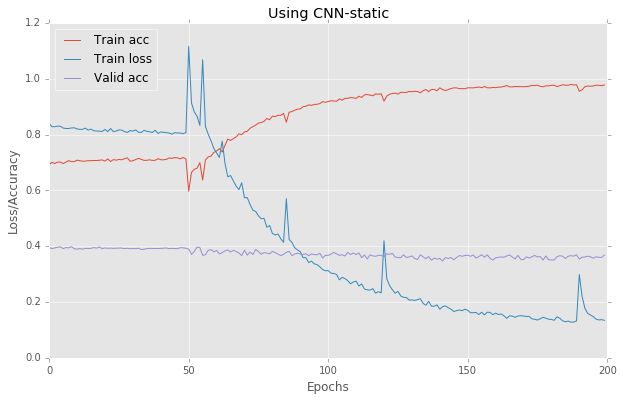

In [35]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(train_acc)
plt.plot(train_loss)
plt.plot(val_acc)
# plt.plot(val_loss)
plt.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Using '+ model_type)
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]
imgName = 'Images/' + model_type + '_' + date + '_' + time + '.jpg'
plt.savefig( imgName, dpi= 200, bbox_inches='tight', transparent=False)
plt.show()